In [ ]:
import pandas as pd
import numpy as np
import nltk

from nltk.tokenize import word_tokenize
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from keras.layers import Conv1D , GlobalMaxPooling1D,MaxPooling1D,Conv2D
from keras.callbacks import ModelCheckpoint

In [ ]:
num_classes = 3

embed_num_dims = 200
max_seq_len = 1000


class_names = ['Positive', 'Negative','Neutral']

In [ ]:
def shuffle(df, n=1, axis=0):
    df = df.copy()
    for _ in range(n):
      df.apply(np.random.shuffle, axis=axis)
    return df

In [ ]:
data= pd.read_excel('/content/daraz.xlsx')

In [ ]:
print(data.columns)

Index(['Sl', 'Text', 'Categore', 'Polarity'], dtype='object')


In [ ]:
data.isnull().values.any()

True

In [ ]:
data.dropna(subset = ["Text","Polarity"], inplace =True )

In [ ]:
data.isnull().values.any()

True

<ipython-input-37-7d7d34880f46>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Polarity', data=data, palette=original_colors)


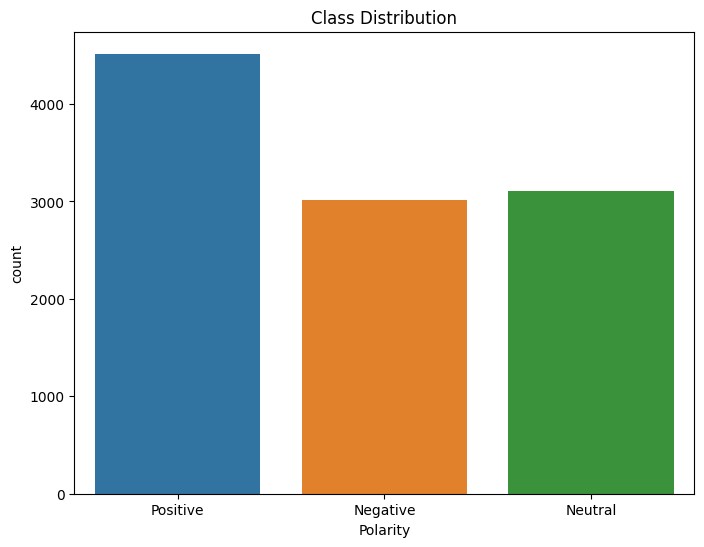

In [ ]:
#import seaborn as sns
#sns.countplot(x='Polarity', data=data)
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette with three colors for the original dataset
original_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Polarity', data=data, palette=original_colors)
plt.title('Class Distribution')
# Show the plots
plt.show()

In [ ]:
data.sort_values(by='Polarity', axis=0, inplace=True)

data.set_index(keys=['Polarity'], drop=False,inplace=True)
Categorys=data['Polarity'].unique().tolist()

In [ ]:
positives = shuffle(data.loc[data.Polarity=='Positive'])
negatives = shuffle(data.loc[data.Polarity=='Negative'])
neutrals = shuffle(data.loc[data.Polarity=='Neutral'])

/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10

In [ ]:
positives_train = positives.iloc[0:int(positives.shape[0]*1)]
positives_test = positives.iloc[0:int(positives.shape[0]*1)]

negatives_train = negatives.iloc[0:int(negatives.shape[0]*1)]
negatives_test = negatives.iloc[0:int(negatives.shape[0]*1)]

neutrals_train = neutrals.iloc[0:int(neutrals.shape[0]*1)]
neutrals_test = neutrals.iloc[0:int(neutrals.shape[0]*1)]

data_train = pd.concat([positives_train, negatives_train, neutrals_train])
data_test = pd.concat([positives_test, negatives_test, neutrals_test])

print(data_train.shape)
print(data_test.shape)

(10637, 4)
(10637, 4)


In [ ]:
X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Polarity
y_test = data_test.Polarity

data = pd.concat([data_train, data_test], ignore_index=True)

print(data['Polarity'].value_counts())
data.head(10)

Polarity
Positive    9032
Neutral     6212
Negative    6030
Name: count, dtype: int64


,Sl,Text,Categore,Polarity
0,3183,দারুন কালি। সবাই নিতে পারেন।,phone,Positive
1,1716,"১১.১১ থেকে ভাইচার,ফ্রি ডেলিভারি, এসব দিয়ে দাম ...",phone,Positive
2,978,"শিপিং চার্জসহ ৪৬৮ টাকা লাগছে, সেইম টু সেইম পেয়...",phone,Positive
3,4021,"ম্যারিকোর প্রডাক্ট সব সময়ই ভালো, ধন্যবাদ দারাজ...",phone,Positive
4,3316,আপনাদের সেবা পেয়ে পরবর্তী ওডারের জন্য অনুপ্রের...,Sneakers for Women,Positive
5,2376,"পন্য ভালো পেয়েছি ধন্যবাদ,",phone,Positive
6,3213,১২ তারিখে অর্ডার দিয়ে একুশ তারিখে পেলাম!! \nএ...,phone,Positive
7,589,ঠিক মত পেয়েছি। ডেট ও আছে পর্যাপ্ত ❤️,phone,Positive
8,3949,একদম লেটেস্ট প্রোডাক্ট। মেয়াদ আছে পুরো ২ বছর। ...,phone,Positive
9,259,প্রডাক্ট দাম হিসাবে খুবই ভালো \nযেমন টা ছবিতে ...,phone,Positive


In [ ]:
print(data.dtypes)


Sl           int64
Text        object
Categore    object
Polarity    object
dtype: object


In [ ]:
print(data_train.Polarity.value_counts())
print(data_test.Polarity.value_counts())

Polarity
Positive    4516
Neutral     3106
Negative    3015
Name: count, dtype: int64
Polarity
Positive    4516
Neutral     3106
Negative    3015
Name: count, dtype: int64


In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)

    return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.tokenize import word_tokenize
def remove_emojis(text):
    # Emoji pattern: Matches any unicode emoji
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]", flags=re.UNICODE)
    english_pattern = re.compile('[a-zA-Z0-9]+', flags=re.I)
    text = english_pattern.sub(r'', text)
    return emoji_pattern.sub(r'', text)

def clean_text(data):
    # Check if data is None or NaN, and convert to an empty string
    if data is None or pd.isnull(data):
        data = ''

    # Convert data to string if it's not already
    if not isinstance(data, str):
        data = str(data)

    # Text cleaning operations
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = remove_emojis(data)
    data_tokens = word_tokenize(data)
    cleaned_data = ' '.join(data_tokens)

    return cleaned_data
def remove_punctuations(my_str):
    # Define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # Display the unpunctuated string
    return no_punct

def preprocessing(text):
    # Preprocess text
    text = clean_text(text)
    text = remove_punctuations(text)
    return text

texts = [clean_text(text) for text in data.Text]
texts_train = [clean_text(text) for text in X_train]
texts_test = [clean_text(text) for text in X_test]

print(texts_train[5])

পন্য ভালো পেয়েছি ধন্যবাদ ,


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 15255


In [ ]:
print("Sentence :--> \n")
print(texts_train[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequence_train[2])+"\n")

Sentence :--> 

শিপিং চার্জসহ ৪৬৮ টাকা লাগছে , সেইম টু সেইম পেয়েছি , প্রোডাক্ট কোয়ালিটি ও ইউ এস বি থ্রি স্পীড যথেষ্ট ভালো , তবে এটায় কোনো ব্রান্ড নেইম উল্যেখ নেই , সেলারের চ্যাট রেসপন্স মোটামুটি , ডেলিভারি স্পীড ছিলো সুপার ফাস্ট- ঢাকা বিভাগের বাইরে ৩ দিনের মধ্যে ডেলিভারি পেয়েছি , যা দারাজ থেকে প্রথমবারের মত এতো দ্রুত ডেলিভারি পেয়েছি।

Sentence Tokenized and Converted into Sequence :--> 

[1270, 1663, 8034, 48, 376, 471, 710, 471, 5, 13, 79, 24, 1953, 3050, 1847, 3051, 1747, 283, 1, 35, 4193, 109, 1391, 8035, 8036, 167, 185, 1118, 472, 86, 17, 1747, 65, 1664, 535, 1954, 5395, 625, 176, 244, 99, 17, 5, 131, 10, 21, 4194, 160, 180, 103, 17, 14]



In [ ]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 851.6 kB/s eta 0:00:00


In [ ]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,   96,   23,   77],
       [   0,    0,    0, ..., 8033,  495,  768],
       [   0,    0,    0, ...,  103,   17,   14],
       ...,
       [   0,    0,    0, ..., 1233,  123, 2690],
       [   0,    0,    0, ...,   15, 8023, 8024],
       [   0,    0,    0, ..., 1629, 3380,  104]], dtype=int32)

In [ ]:
encoding = {
    'Positive': 0,
    'Negative': 1,
    'Neutral': 2
}

y_train = [encoding[x] for x in data_train.Polarity]
y_test = [encoding[x] for x in data_test.Polarity]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
GLOVE_DIM = 200

import urllib.request
import zipfile
import os

fname = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.twitter.27B.zip',
                              'glove.twitter.27B.zip')
    print('Unzipping...')
    with zipfile.ZipFile('glove.twitter.27B.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    print('done.')

    os.remove('glove.twitter.27B.zip')

Unzipping...
done.


In [ ]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

NB_WORDS = vocab_size
MAX_LEN = max_seq_len

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))
for w, i in tokenizer.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
          emb_matrix[i] = vect
    else:
        break

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, SpatialDropout1D, Dropout, Dense

model = Sequential()
model.add(Embedding(vocab_size,
                    GLOVE_DIM,
                    input_length=max_seq_len,
                    weights=[emb_matrix],
                    trainable=False))

model.add(SpatialDropout1D(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         3051200   
                                                                 
 spatial_dropout1d (Spatial  (None, 1000, 200)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 1000, 64)          67840     
                                                                 
 dropout (Dropout)           (None, 1000, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
from time import time
t1 = time()

batch_size = 256
epochs = 70

print(X_test_pad.shape)
print(y_test.shape)

print(X_train_pad.shape)
print(y_train.shape)

(10637, 1000)
(10637, 3)
(10637, 1000)
(10637, 3)


In [ ]:
hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad, y_test))

Epoch 1/70
42/42 [==============================] - 18s 213ms/step - loss: 1.0109 - accuracy: 0.4913 - val_loss: 0.9320 - val_accuracy: 0.5640
Epoch 2/70
42/42 [==============================] - 7s 179ms/step - loss: 0.9196 - accuracy: 0.5784 - val_loss: 0.8746 - val_accuracy: 0.5927
Epoch 3/70
42/42 [==============================] - 7s 174ms/step - loss: 0.8890 - accuracy: 0.5950 - val_loss: 0.8436 - val_accuracy: 0.6251
Epoch 4/70
42/42 [==============================] - 7s 175ms/step - loss: 0.8642 - accuracy: 0.6036 - val_loss: 0.8171 - val_accuracy: 0.6373
Epoch 5/70
42/42 [==============================] - 9s 210ms/step - loss: 0.8445 - accuracy: 0.6155 - val_loss: 0.7987 - val_accuracy: 0.6391
Epoch 6/70
42/42 [==============================] - 9s 208ms/step - loss: 0.8281 - accuracy: 0.6248 - val_loss: 0.7771 - val_accuracy: 0.6511
Epoch 7/70
42/42 [==============================] - 9s 212ms/step - loss: 0.8145 - accuracy: 0.6308 - val_loss: 0.7694 - val_accuracy: 0.6499
Epoch

In [ ]:
t2 = time()
t_delta = round(t2-t1,2)
print(t_delta)

539.91


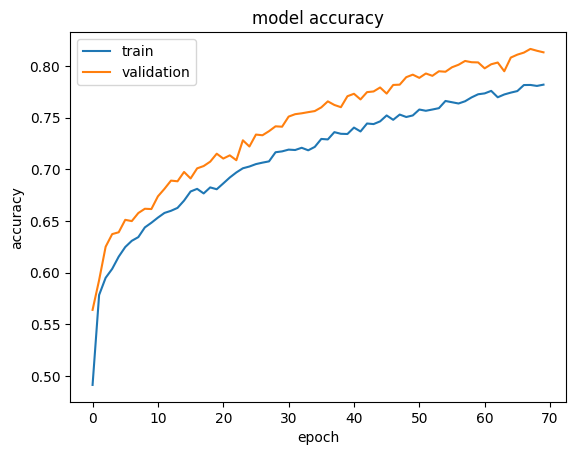

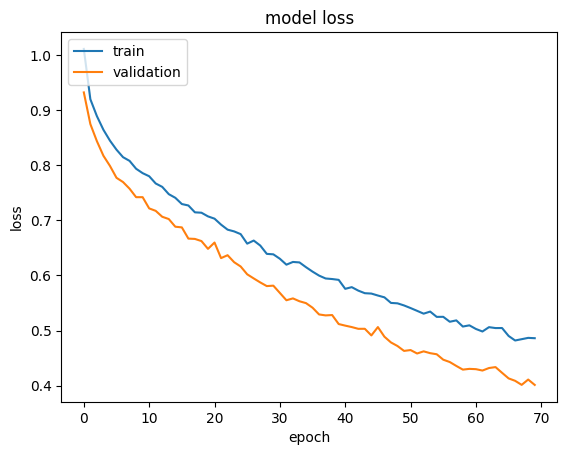

In [ ]:
# Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

333/333 [==============================] - 12s 33ms/step


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='micro'))
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='macro'))
print(precision_recall_fscore_support(data_test.Polarity, predictions, average='weighted'))

(0.8132932217730563, 0.8132932217730563, 0.8132932217730563, None)
(0.8319886751581769, 0.7985601961517567, 0.8100235044099677, None)
(0.822228745818339, 0.8132932217730563, 0.812356393304266, None)



F1 Score: 81.33


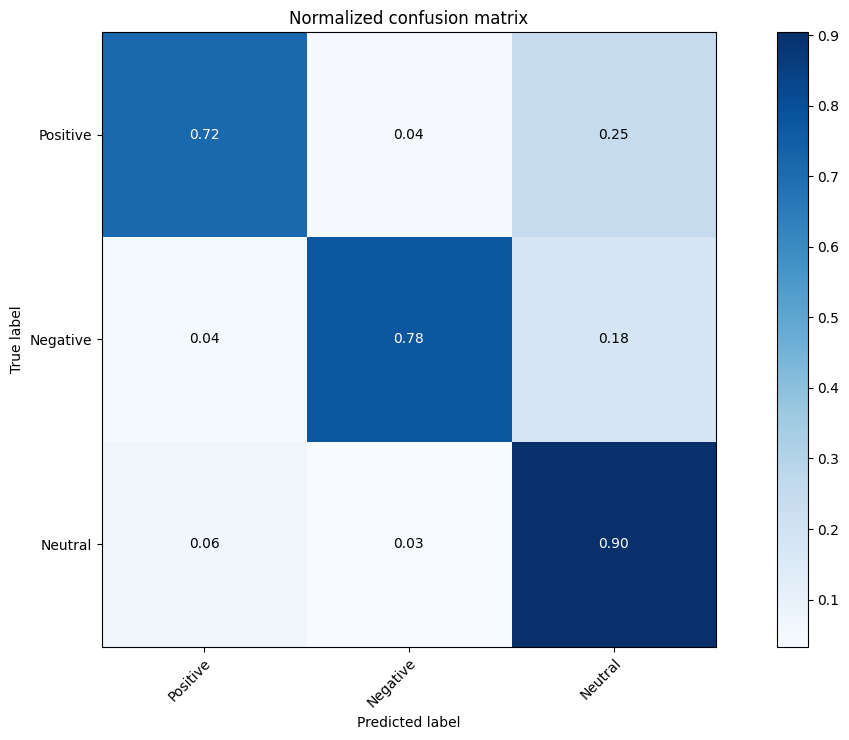

Message: ১২ তারিখে অর্ডার দিয়ে একুশ তারিখে পেলাম!! 
এর চাইতে স্লো ডেলিভারি আর কত হতে পারে?! 
তাও আবার ই-দেশ কুরিয়ার এর হেড অফিসে কমপ্লেন করে ডেলিভারি ম্যান কে ফোন টোন করে দীর্ঘ প্রতিক্ষার পরে পেলাম।

যাইহোক ধন্যবাদ অথেনটিক প্রোডাক্ট দেয়ার জন্য। এখন কেমন সার্ভিস দেয় সেটায় দেখার বিষয়!
Predicted: Positive


In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Polarity, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Polarity, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Message: {}\nPredicted: {}'.format(X_test[6], predictions[6]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(data_test.Polarity, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(data_test.Polarity, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(data_test.Polarity, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(data_test.Polarity, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(data_test.Polarity, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(data_test.Polarity, predictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(data_test.Polarity, predictions, target_names=class_names))


Accuracy: 0.81

Micro Precision: 0.81
Micro Recall: 0.81
Micro F1-score: 0.81

Macro Precision: 0.83
Macro Recall: 0.80
Macro F1-score: 0.81

Weighted Precision: 0.82
Weighted Recall: 0.81
Weighted F1-score: 0.81

Classification Report

              precision    recall  f1-score   support

    Positive       0.84      0.72      0.77      3015
    Negative       0.90      0.78      0.83      3106
     Neutral       0.76      0.90      0.83      4516

    accuracy                           0.81     10637
   macro avg       0.83      0.80      0.81     10637
weighted avg       0.82      0.81      0.81     10637



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn import metrics

cm = confusion_matrix(data_test.Polarity, predictions)

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn import metrics
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))


Sensitivity :  0.9398692810457516
Specificity :  0.9537000395726157
false positive rate :  0.04629996042738425
false negative rate :  0.06013071895424837
Negative Predictive Value :  0.945839874411303
False Discovery rate :  0.051451187335092345


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,model.predict(X_test_pad)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,model.predict(X_test_pad)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test_pad))))
print('Cohen_Kappa_Score:', cohen_kappa_score(data_test.Polarity, predictions))

333/333 [==============================] - 14s 41ms/step
Mean Absolute Error: 0.16305254
333/333 [==============================] - 10s 30ms/step
Mean Squared Error: 0.07886108
333/333 [==============================] - 11s 33ms/step
Root Mean Squared Error: 0.28082216
Cohen_Kappa_Score: 0.7096277471032852
